Nama : Cahya Fadhilah Yasmien

NIM : 220411100106

Matakuliah : PSD

Data yang digunakan dalam pengerjaan tugas ini berupa data time series penjualan coffe sales yang didapat dari website kaggle [Coffe Sales](https://www.kaggle.com/datasets/ihelon/coffee-sales/data). Dengan memprediksi jumlah pengunjung yang membeli di coffe sales.

In [440]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
import xgboost as xgb

## Menampilkan Data

In [441]:
data = '/content/drive/MyDrive/PSD/sales.csv'
df_baru = pd.read_csv(data, delimiter=';')
df_baru

,date,jumlah_pengunjung
0,01/03/2024,11
1,02/03/2024,7
2,03/03/2024,10
3,04/03/2024,4
4,05/03/2024,9
...,...,...
213,03/10/2024,8
214,04/10/2024,9
215,05/10/2024,6
216,06/10/2024,20


## Data Prepocessing

In [442]:
df_baru.head()

,date,jumlah_pengunjung
0,01/03/2024,11
1,02/03/2024,7
2,03/03/2024,10
3,04/03/2024,4
4,05/03/2024,9


In [443]:
df_baru.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 218 entries, 0 to 217
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   date               218 non-null    object
 1   jumlah_pengunjung  218 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 3.5+ KB


In [444]:
df_baru.isnull().sum()

,0
date,0
jumlah_pengunjung,0


In [445]:
deskripsi = df_baru.describe()
deskripsi

,jumlah_pengunjung
count,218.000000
mean,8.394495
std,4.458758
min,1.000000
25%,5.000000
50%,8.000000
75%,11.000000
max,24.000000


## Normalisasi

In [446]:
df_baru = pd.DataFrame(df_baru)
df_baru['date'] = pd.to_datetime(df_baru['date'], format='%d/%m/%Y')
features = ['date', 'jumlah_pengunjung']
target = ['jumlah_pengunjung']

# Scale the data
scaler = MinMaxScaler()
df_baru[target] = scaler.fit_transform(df_baru[target])
df_normalized = df_baru[['date'] + target].copy()
df_baru

,date,jumlah_pengunjung
0,2024-03-01,0.434783
1,2024-03-02,0.260870
2,2024-03-03,0.391304
3,2024-03-04,0.130435
4,2024-03-05,0.347826
...,...,...
213,2024-10-03,0.304348
214,2024-10-04,0.347826
215,2024-10-05,0.217391
216,2024-10-06,0.826087


## Sliding Window

In [447]:
df_baru = pd.DataFrame(df_baru)
# df_baru['date'] = df_baru.index
df_baru['date'] = pd.to_datetime(df_baru['date'], format='%d/%m/%Y')
df_baru.set_index('date', inplace=True)
def sliding_window(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:(i + window_size)].flatten())
        y.append(data[i + window_size])
    return pd.DataFrame(X), pd.DataFrame(y)

# Menggunakan fungsi sliding window
window_size = 3
X, y = sliding_window(df_baru['jumlah_pengunjung'].values.reshape(-1, 1), window_size)

# Menampilkan hasil
X.columns = [f'lag_{i+1}' for i in range(window_size)]
y.columns = ['target']
result = pd.concat([X, y], axis=1)

print(result.head())

      lag_1     lag_2     lag_3    target
0  0.434783  0.260870  0.391304  0.130435
1  0.260870  0.391304  0.130435  0.347826
2  0.391304  0.130435  0.347826  0.173913
3  0.130435  0.347826  0.173913  0.217391
4  0.347826  0.173913  0.217391  0.304348


## Transformasi Data


In [448]:
# Membagi data menjadi data train dan test (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Menampilkan jumlah data train dan test
print("Jumlah data train:", len(X_train))
print("Jumlah data test:", len(X_test))

Jumlah data train: 172
Jumlah data test: 43


## Modeling

### Begging Regresor

In [449]:
model_begging = BaggingRegressor(estimator=DecisionTreeRegressor(), n_estimators=20, random_state=42)
model_begging.fit(X_train, y_train)
y_pred = model_begging.predict(X_test)

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_bagging.py:581: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return column_or_1d(y, warn=True)


jumlah pengunjung 1 hari ke depan  [0.4217391304347828, 0.33260869565217405]


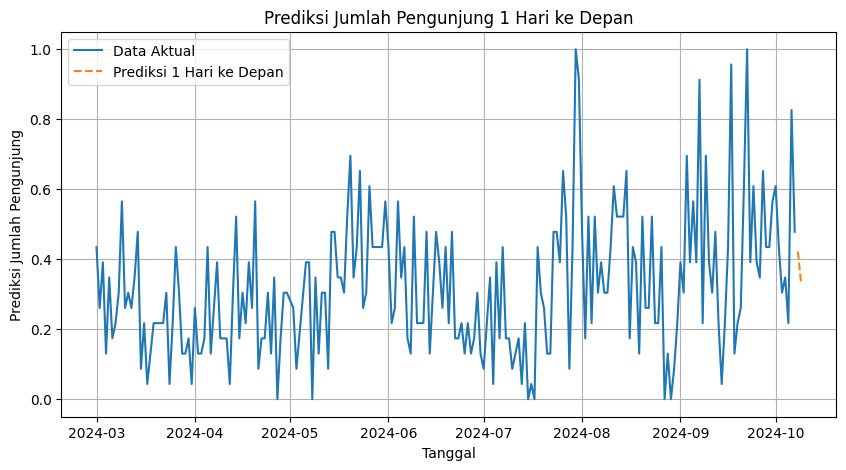

In [450]:
# memprediksi jumlah pengunjung 7 hari ke depan
def predict_future(model, last_window, steps=1):
    future_predictions = []
    for _ in range(steps):
        current_window = pd.DataFrame([last_window], columns=['lag_1', 'lag_2', 'lag_3'])
        prediction = model.predict(current_window)
        future_predictions.append(prediction[0])
        # Update current window dengan prediksi terbaru
        last_window = np.roll(last_window, -1)
        last_window[-1] = prediction[0]
    return future_predictions

# # Ambil jendela terakhir dari data
last_window = X.values[-1]

# # Prediksi 7 hari ke depan
future_steps = 2
future_predictions = predict_future(model_begging, last_window, future_steps)

# # Tampilkan prediksi masa depan
# future_df = pd.date_range(start=df_baru['date'].iloc[-1] + pd.DateOffset(days=1), periods=future_steps, freq='D')
future_df = pd.date_range(start=df_baru.index[-1] + pd.DateOffset(days=1), periods=future_steps, freq='D')
print("jumlah pengunjung 1 hari ke depan ",future_predictions)

plt.figure(figsize=(10, 5))
plt.plot(df_baru.index, df_baru['jumlah_pengunjung'], label='Data Aktual')
plt.plot(future_df, future_predictions, label='Prediksi 1 Hari ke Depan', linestyle='--')
plt.title('Prediksi Jumlah Pengunjung 1 Hari ke Depan')
plt.xlabel('Tanggal')
plt.ylabel('Prediksi Jumlah Pengunjung')
plt.grid()
plt.legend()
plt.show()

In [451]:
# Menghitung MSE, MAE, RMSE, R² dan MAPE
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)

In [452]:
print(f"{'Bagging Regressor'} \n MSE: {mse}\n MAE: {mae}\n RMSE: {rmse}\n R²: {r2}\n MAPE: {mape}%")

Bagging Regressor 
 MSE: 0.03836109377060711
 MAE: 0.15534209639366364
 RMSE: 0.19585988300468044
 R²: -0.02039028064831938
 MAPE: 32331200560496.82%


### Linear Regression

In [453]:
# Model Linear Regression
model_linear = LinearRegression()
model_linear.fit(X_train, y_train)
y_pred = model_linear.predict(X_test)

jumlah pengunjung 1 hari ke depan  [array([0.40430971]), array([0.42857037])]


<ipython-input-454-f50be0bac4a6>:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  last_window[-1] = prediction[0]
<ipython-input-454-f50be0bac4a6>:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  last_window[-1] = prediction[0]


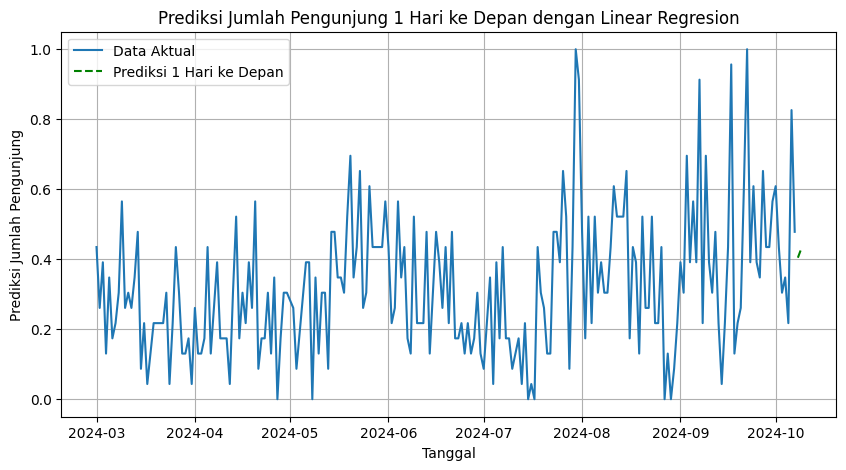

In [454]:
# memprediksi jumlah pengunjung 7 hari ke depan
def predict_future(model, last_window, steps=1):
    future_predictions = []
    for _ in range(steps):
        current_window = pd.DataFrame([last_window], columns=['lag_1', 'lag_2', 'lag_3'])
        prediction = model.predict(current_window)
        future_predictions.append(prediction[0])
        # Update current window dengan prediksi terbaru
        last_window = np.roll(last_window, -1)
        last_window[-1] = prediction[0]
    return future_predictions

# # Ambil jendela terakhir dari data
last_window = X.values[-1]

# # Prediksi 7 hari ke depan
future_steps = 2
future_predictions = predict_future(model_linear, last_window, future_steps)

# # Tampilkan prediksi masa depan
# future_df = pd.date_range(start=df_baru['date'].iloc[-1] + pd.DateOffset(days=1), periods=future_steps, freq='D')
future_df = pd.date_range(start=df_baru.index[-1] + pd.DateOffset(days=1), periods=future_steps, freq='D')
print("jumlah pengunjung 1 hari ke depan ",future_predictions)

plt.figure(figsize=(10, 5))
plt.plot(df_baru.index, df_baru['jumlah_pengunjung'], label='Data Aktual')
# plt.plot(X_test.index, y_pred, label='Prediksi Linear Regression (Test)', color='green', linestyle='--')
plt.plot(future_df, future_predictions, label='Prediksi 1 Hari ke Depan',color='green', linestyle='--')
plt.title('Prediksi Jumlah Pengunjung 1 Hari ke Depan dengan Linear Regresion')
plt.xlabel('Tanggal')
plt.ylabel('Prediksi Jumlah Pengunjung')
plt.grid()
plt.legend()
plt.show()

In [455]:
# Menghitung MSE, MAE, RMSE, R² dan MAPE
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)

In [456]:
print(f"{'Bagging Regressor'} \n MSE: {mse}\n MAE: {mae}\n RMSE: {rmse}\n R²: {r2}\n MAPE: {mape}%")

Bagging Regressor 
 MSE: 0.031921917435379824
 MAE: 0.13852758931038478
 RMSE: 0.17866705749908074
 R²: 0.15088932329459503
 MAPE: 24357860623485.21%


### Perbandingan MAPE Decission Tree dengan Linear Regression

In [457]:
data = '/content/drive/MyDrive/PSD/perbandingan.csv'
df = pd.read_csv(data, delimiter=';')
df

,Unnamed: 0,lag_3,lag_4,lag_5,lag_6
0,Decission Tree,0.7331033376108617%,0.5938641240770174%,10738053311257800%,0.4683156861568284%
1,Linear Regression,0.6209078597456028%,0.44658891220731706%,0.9335942381454022%,0.474347510183352%
